<a href="https://colab.research.google.com/github/NataliaKor/tutorial/blob/main/tutorial-ML-for-GWPE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial on Machine Learning for Gravitational Wave Parameter Estimation

### Stephen Green *stephen.green2@nottingham.ac.uk* and Natalia Korsakova *korsakova@apc.in2p3.fr*

---

In this tutorial we will build a simple **parameter estimation** neural network:
* **Training data:** FastGB waveforms, parametrized only by initial frequency (f0) and amplitude; noise added during training
* **Posterior model 1:** Gaussian with learnable (diagonal) covariance matrix
* **Posterior model 2:** Learned with the Normalising Flow

This should run in about a minute on a laptop (this has to be checked).

### Exercises
1. Add inclination in addition to f0 and amp
2. Extend the Gaussian distribution to include general covariance
3. Make a PP plot

## Imports

In [1]:
!pip install corner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import corner
# Make a check if CPU use np and if GPU use cupy
import cupy as cp

In [4]:
# pytorch imports
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
from torch.utils.data import DataLoader

In [5]:
!git clone https://github.com/NataliaKor/GBGPU.git

Cloning into 'GBGPU'...
remote: Enumerating objects: 1125, done.
remote: Counting objects: 100% (299/299), done.
remote: Compressing objects: 100% (200/200), done.
remote: Total 1125 (delta 140), reused 208 (delta 97), pack-reused 826
Receiving objects: 100% (1125/1125), 12.08 MiB | 31.47 MiB/s, done.
Resolving deltas: 100% (630/630), done.


In [18]:
from GBGPU.gbgpu.gbgpu import GBGPU
from GBGPU.gbgpu.noisemodel import AnalyticNoise 

In [7]:
N_points = None

# Create waveform
gb = GBGPU(use_gpu=True)


## Training data

Generate a training set that (for simplicity) samples only over amplitudes and frequencies. Generate frequency-domain waveforms using FastGB. We will add noise during training.

**Exercise:** Add more parameters

In [8]:
num_samples = 10000  # size of the training set

# Choose something in the lower frequencies
f0_min = 0.010062
f0_max = 0.010085

amp_min = -23.
amp_max = -21.

# frequency
f0 = np.random.uniform(f0_min, f0_max, num_samples)

# amplitude
amp = 10**np.random.uniform(amp_min, amp_max, num_samples)



In [9]:
# Fixed parameters

fdot = 1.79e-15
lam  = 4.36
beta = 2.18
iota = 0.67
phi0 = 5.48
psi  = 0.43


In [10]:
# Waveform settings


Tobs = 31536000.0
dt = 15.0
df = 1./Tobs

fvec_min = 0.010053
fvec_max = 0.010094

# Put the waveform in the common frequency band 
k_min = np.round(fvec_min/df).astype(int)
k_max = np.round(fvec_max/df).astype(int)
num = k_max - k_min
freqs = (np.arange(num) + k_min)*df

#f_lower = 20.0
#f_final = 1024.0
#T = 1.0

#delta_f = 1 / T
#nf = int(f_final / delta_f) + 1
#f_array = np.linspace(0.0, f_final, num=nf)

In [19]:
# Noise PSD

noise = AnalyticNoise(freqs)
psdA, psdE = noise.psd(option="A"), noise.psd(option="E")

#psd[0] = psd[1]  # Fix up endpoints
#psd[-1] = psd[-2]

asdA = np.sqrt(psdA)
asdE = np.sqrt(psdE)

In [20]:
# Generate training waveforms

A_list = []
E_list = []

for i in range(num_samples):
    
    #mass1, mass2 = masses[i]

    params = np.array([amp[i], f0[i], fdot, 0.0, -phi0, iota, psi, lam, beta])
    gb.run_wave(*params, N = N_points, dt = dt, T = Tobs, oversample = 1)#oversample=2)
    
    #hp, hc = get_fd_waveform(approximant=approximant,
    #                         mass1=mass1, mass2=mass2,
    #                         inclination=inclination,
    #                         distance=distance,
    #                         coa_phase = phase,
    #                         spin1x=spin1x, spin1y=spin1y, spin1z=spin1z,
    #                         spin2x=spin2x, spin2y=spin2y, spin2z=spin2z,        
    #                         delta_f=delta_f,
    #                         f_lower=f_lower, f_final=f_final)
    
    #f_array = np.array(hp.sample_frequencies)
    
    i_start = (gb.start_inds.get() - k_min).astype(np.int32)
    i_end = (gb.start_inds.get() - k_min + gb.N).astype(np.int32)

    A_out = cp.zeros((1, num), dtype=cp.complex128)
    E_out = cp.zeros((1, num), dtype=cp.complex128)

    # Put waveforms in the same frequency range
    A_out[i_start : i_end] = gb.A
    E_out[i_start : i_end] = gb.E

    # Whiten waveforms and rescale so that white noise has unit variance
    #hp = hp / asd * np.sqrt(4.0 * delta_f)
    #hc = hc / asd * np.sqrt(4.0 * delta_f)
    A_white = A_out * cp.sqrt(4.0 * df)* dt/cp.array(asdA)
    E_white = E_out * cp.sqrt(4.0 * df)* dt/cp.array(asdE)

    A_list.append(A_white)
    E_list.append(E_white)

Awf = np.array(A_list)
Ewf = np.array(E_list)

NameError: ignored

In [ ]:
# Sample waveform

plt.plot(f_array, Awf[0].real)
plt.xscale('log')
plt.xlabel('$f$')
plt.ylabel('Re $A$')
#plt.xlim((10, f_final))
plt.show()

### Package into a pytorch Dataset

In [ ]:
# Parameters
#

#m1 = masses[:, 0]
#m2 = masses[:, 1]

#Mc = (m1 * m2)**(3/5) / (m1 + m2)**(1/35)
#q = m2 / m1

#parameters = np.stack((Mc, q), axis=1).astype(np.float32)
parameters = np.stack((f0, amp), axis=1).astype(np.float32)

In [ ]:
# For best training, parameters should be standardized (zero mean, unit variance across the training set)

parameters_mean = np.mean(parameters, axis=0)
parameters_std = np.std(parameters, axis=0)

parameters_standardized = (parameters - parameters_mean) / parameters_std

In [ ]:
# Waveforms
#
# Truncate the arrays to remove zeros below f_lower, and repackage real and imaginary parts
#
# Only consider h_plus for now

#lower_cut = int(f_lower / delta_f)
#waveforms = np.hstack((hp.real[:, lower_cut:], hp.imag[:, lower_cut:])).astype(np.float32)
waveforms = np.hstack((Awf.real[:, :], Awf.imag[:, :]), Ewf.real[:, :], Ewf.imag[:, :]).astype(np.float32)

In [ ]:
class WaveformDataset(Dataset):
    
    def __init__(self, parameters, waveforms):
        self.parameters = parameters
        self.waveforms = waveforms

    def __len__(self):
        return len(self.parameters)

    def __getitem__(self, idx):
        params = self.parameters[idx]
        signal = self.waveforms[idx]
        
        # Add unit normal noise to the signal
        noise = np.random.normal(size = signal.shape).astype(np.float32)
        data = signal + noise
        
        return torch.tensor(data), torch.tensor(params)

In [ ]:
waveform_dataset = WaveformDataset(parameters_standardized, waveforms)

In [ ]:
# We can sample from the WaveformDataset. This gives us pairs of data and parameters, different noise realizations each time.

x, y = waveform_dataset[0]
plt.plot(x)

## Posterior Model

In [ ]:
# Neural networks are constructed by subclassing nn.Module
#
# This has to implement an __init__() and forward() method

class NeuralNetwork(nn.Module):
    
    def __init__(self, input_dim, hidden_dims, output_dim, activation=nn.ReLU()):
        super(NeuralNetwork, self).__init__()
        
        # Hidden layers
        hidden_net_list = []
        hidden_net_list.append(
            nn.Linear(input_dim, hidden_dims[0]))
        for i in range(1, len(hidden_dims)):
            hidden_net_list.append(nn.Linear(hidden_dims[i-1], hidden_dims[i]))
        self.hidden_net_list = nn.ModuleList(hidden_net_list)
        
        # Output layers
        self.output_mean = nn.Linear(hidden_dims[-1], output_dim)
        self.output_log_sigma = nn.Linear(hidden_dims[-1], output_dim)
        
        # Activation function
        self.activation = activation
        
    def forward(self, x):
        """Pass x through all the layers of the network and return the Gaussian distribution"""
        
        h = x
        for layer in self.hidden_net_list:
            h = self.activation(layer(h))

        # Output layer defines a Gaussian
        mean = self.output_mean(h)
        log_sigma = self.output_log_sigma(h)
        sigma = torch.exp(log_sigma)
        
        # Create the Gaussian distribution
        dist = torch.distributions.MultivariateNormal(loc=mean, scale_tril=torch.diag_embed(sigma))
        
        return dist

In [ ]:
input_dim = waveforms.shape[-1]
output_dim = parameters.shape[-1]
hidden_dims = [512, 256, 128, 64, 32]

model = NeuralNetwork(input_dim, hidden_dims, output_dim)

In [ ]:
print(model)

## Training

In [ ]:
# Split the dataset into training and test sets

train_fraction = 0.8
num_train = int(round(train_fraction * num_samples))
num_test = num_samples - num_train
train_dataset, test_dataset = random_split(waveform_dataset, [num_train, num_test])

# The DataLoader is used in training

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
# The DataLoaders iterate over samples, returning torch tensors containing a batch of data

train_features, train_labels = next(iter(train_dataloader))

In [ ]:
train_features

In [ ]:
train_features.shape

In [ ]:
# We use the Adam optimizer.

optimizer = torch.optim.Adam(model.parameters())

In [ ]:
# Training and test loops

def train_loop(dataloader, model, optimizer):
 
    size = len(dataloader.dataset)
    train_loss = 0
    
    for batch, (X, y) in enumerate(dataloader):
        # Compute negative log probability loss
        dist = model(X)        
        loss = - dist.log_prob(y)
        
        train_loss += loss.detach().sum()
        loss = loss.mean()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 50 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"Loss: {loss:>7f}  [{current:>5d}/{size:>5d} samples]")
            
    average_loss = train_loss.item() / size
    print('Average loss: {:.4f}'.format(average_loss))
    return average_loss
            
        
        
def test_loop(dataloader, model):
    size = len(dataloader.dataset)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            dist = model(X)
            loss = - dist.log_prob(y)
            test_loss += loss.sum()

    test_loss /= size
    print(f"Test loss: {test_loss:>8f} \n")
    return test_loss

In [ ]:
epochs = 20
train_history = []
test_history = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss = train_loop(train_dataloader, model, optimizer)
    train_history.append(loss)
    loss = test_loop(test_dataloader, model)
    test_history.append(loss)
print("Done!")

In [ ]:
epochs = np.arange(1, len(train_history) + 1)
plt.plot(epochs, train_history, label = 'train loss')
plt.plot(epochs, test_history, label = 'test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



```
# This is formatted as code
```

## Evaluation

### Posterior plots

In [ ]:
num_posteriors = 10
num_samples = 10000

for n in range(num_posteriors):
    test_x, test_y = test_dataset[n]

    # Predict a posterior
    dist = model(test_x)

    # Sample the posterior
    pred_samples = dist.sample((10000,)).numpy()

    # Undo the standardization
    pred_samples = parameters_std * pred_samples + parameters_mean
    truth = parameters_std * test_y.numpy() + parameters_mean

    # Plot
    corner.corner(pred_samples, truths=truth, labels=['$f0$', '$amp$'])
    plt.show()

Implement RealNVP Normalising flow (https://arxiv.org/abs/1605.08803).



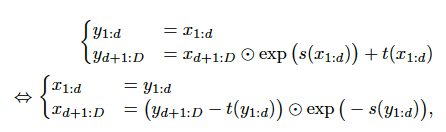

Functions **s** and **t** should be parameterised by the Neural Network.  
Base distribution is chosen to be Gaussian Multivariate Distribution.

In [ ]:
nets = lambda: nn.Sequential(nn.Linear(2, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, 2), nn.Tanh())
nett = lambda: nn.Sequential(nn.Linear(2, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, 2))
masks = torch.from_numpy(np.array([[0, 1], [1, 0]] * 3).astype(np.float32))
prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))

In [ ]:
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP, self).__init__()
        
        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(masks))])
        
    def g(self, z):
        x = z
        for i in range(len(self.t)):
            x_ = x*self.mask[i]
            s = self.s[i](x_)*(1 - self.mask[i])
            t = self.t[i](x_)*(1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
        return x

    def f(self, x):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            s = self.s[i](z_) * (1-self.mask[i])
            t = self.t[i](z_) * (1-self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J -= s.sum(dim=1)
        return z, log_det_J
    
    def log_prob(self,x):
        z, logp = self.f(x)
        return self.prior.log_prob(z) + logp
        

In [ ]:
flow = RealNVP(nets, nett, masks, prior)

Choose optimiser.  
Define loss function.  
Choose dataset to demonstrate the performance.

In [ ]:
optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=1e-4)
for t in range(5001):    
    noisy_moons = datasets.make_moons(n_samples=100, noise=.05)[0].astype(np.float32)
    loss = -flow.log_prob(torch.from_numpy(noisy_moons)).mean()
    
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    
    if t % 500 == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)

Plot the results.

In [ ]:
noisy_moons = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
z = flow.f(torch.from_numpy(noisy_moons))[0].detach().numpy()
plt.subplot(221)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z = f(X)$')

z = np.random.multivariate_normal(np.zeros(2), np.eye(2), 1000)
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z \sim p(z)$')

plt.subplot(223)
x = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
plt.scatter(x[:, 0], x[:, 1], c='r')
plt.title(r'$X \sim p(X)$')

plt.subplot(224)
x = flow.sample(1000).detach().numpy()
plt.scatter(x[:, 0, 0], x[:, 0, 1], c='r')
plt.title(r'$X = g(z)$')

Rewrite the flow conditioning it on the data.

In [ ]:
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP, self).__init__()
        
        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(masks))])
        
    def g(self, z, w):
        x = z
        for i in range(len(self.t)):
            x_ = x*self.mask[i]
            x_wf = torch.cat([x_, w],dim=1)
            s = self.s[i](x_wf)*(1 - self.mask[i])
            t = self.t[i](x_wf)*(1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
        return x

    def f(self, x, w):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            z_wf = torch.cat([z_, w],dim=1)
            s = self.s[i](z_wf) * (1-self.mask[i])
            t = self.t[i](z_wf) * (1-self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J -= s.sum(dim=1)
        return z, log_det_J
    
    def log_prob(self, x, w):
        z, logp = self.f(x, w)
        return self.prior.log_prob(z) + logp
        
